In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
import seaborn as sn

In [2]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from scipy.optimize import minimize
from arch import arch_model

import matplotlib.pyplot as plt
import matplotlib as mpl
from itertools import product

In [3]:
from livelossplot import PlotLossesKeras
from keras_sequential_ascii import keras2ascii

In [4]:
sn.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (20,10)
plt.rcParams.update({'font.size': 12})
pd.set_option('display.max_columns', 2000)

In [5]:
path = 'sunspots/Sunspots.csv'

In [6]:
df = pd.read_csv(path, index_col=['Date'], usecols=['Date', 'Monthly Mean Total Sunspot Number'])
df.index = pd.to_datetime(df.index.values)
df_quarter = df.resample('Q').mean()

In [7]:
df.head()

,Monthly Mean Total Sunspot Number
1749-01-31,96.7
1749-02-28,104.3
1749-03-31,116.7
1749-04-30,92.8
1749-05-31,141.7


/home/aksel/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


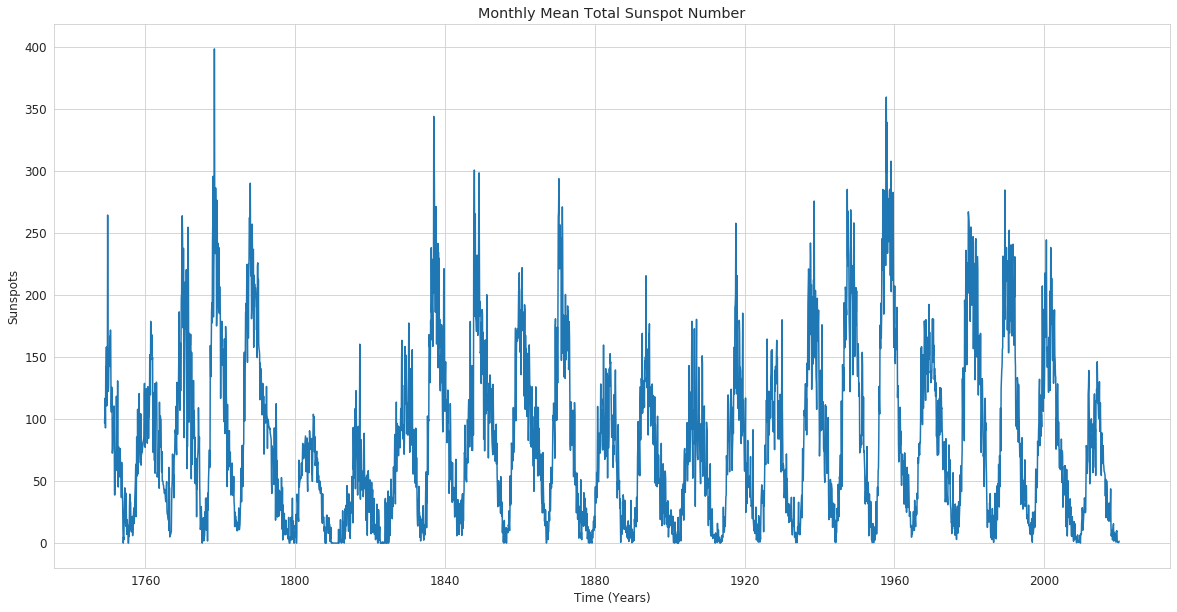

In [8]:
plt.plot(pd.to_datetime(df.index.values), df.values)
plt.xlabel("Time (Years)")
plt.ylabel("Sunspots")
plt.title('Monthly Mean Total Sunspot Number')
plt.show()

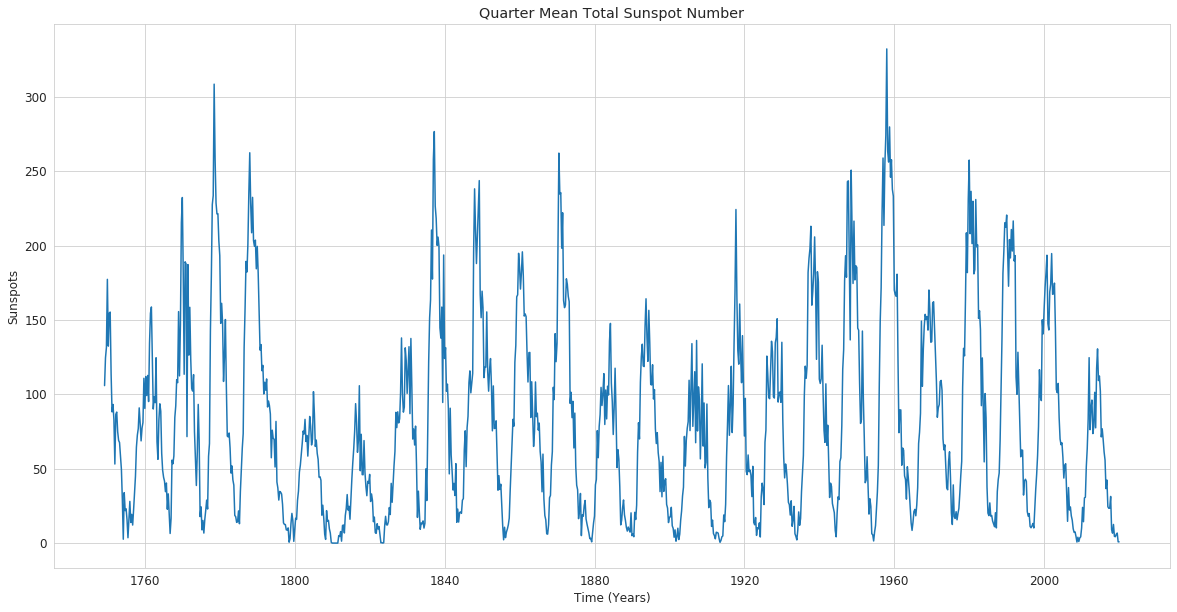

In [11]:
plt.plot(pd.to_datetime(df_quarter.index.values), df_quarter.values)
plt.xlabel("Time (Years)")
plt.ylabel("Sunspots")
plt.title('Quarter Mean Total Sunspot Number')
plt.show()

In [14]:
# 25 peaks
(df.index[-1].year - df.index[0].year) / 25 # Each 11 years repeat peak

10.8

Each 11 years (11*12 = 132 months) repeat peak

Критерий Дики-Фуллера: p=0.000000


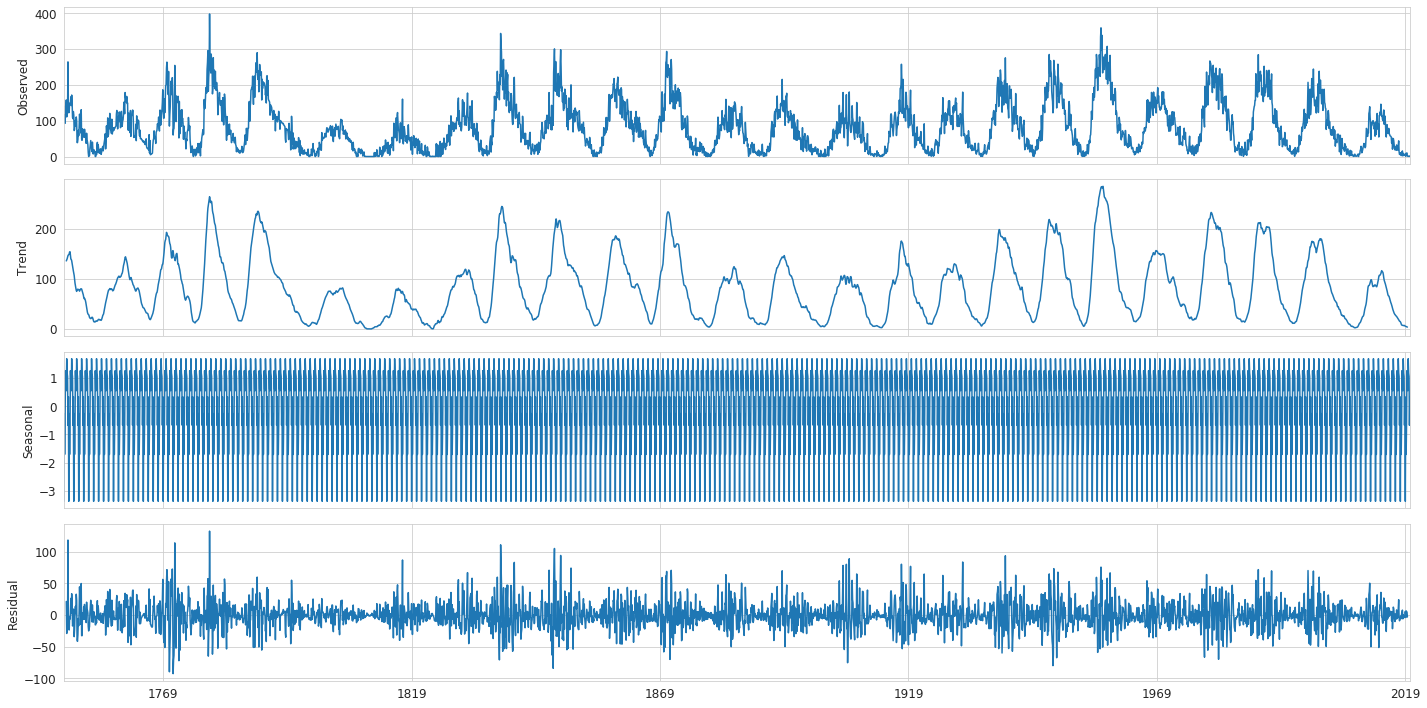

In [10]:
sm.tsa.seasonal_decompose(df['Monthly Mean Total Sunspot Number']).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df['Monthly Mean Total Sunspot Number'])[1])

In [17]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

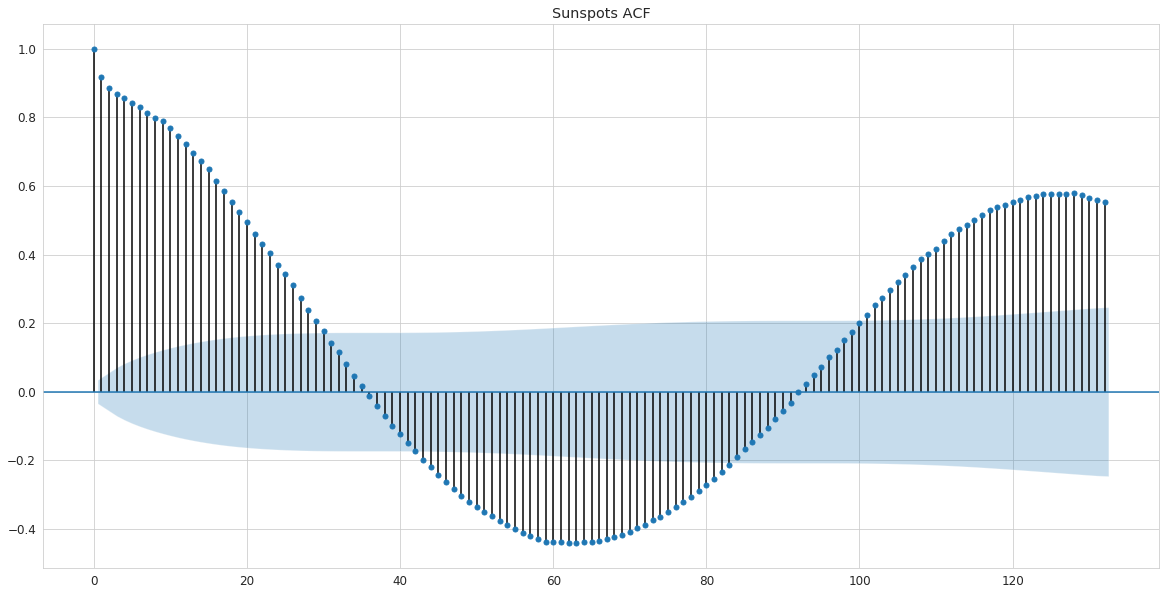

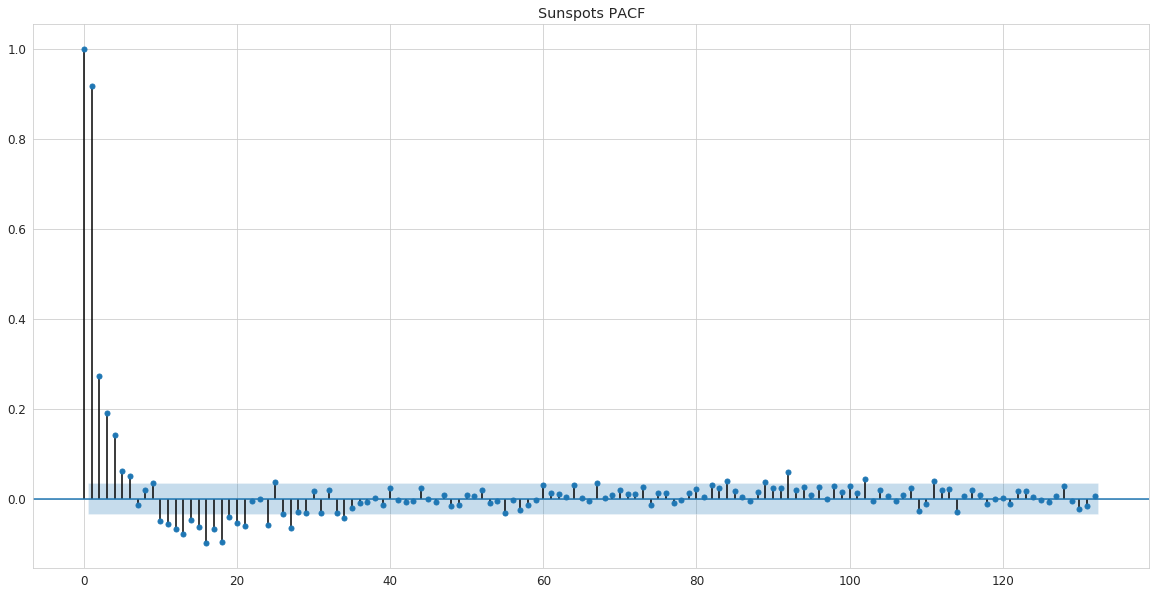

In [18]:
plot_acf(df,lags=132, title='Sunspots ACF')
plot_pacf(df,lags=132, title='Sunspots PACF')
plt.show()

In [37]:
from statsmodels.tsa.stattools import adfuller
def printADFTest(serie):
    test = adfuller(serie, autolag='AIC')
    print('adf: ', test[0])
    print('p-value: ', test[1])
    print('Critical values: ', test[4])
    if test[0]> test[4]['5%']: 
        print ('Есть единичные корни, ряд не стационарен')
    else:
        print('Единичных корней нет, ряд стационарен')

In [38]:
#d = 0
printADFTest(df['Monthly Mean Total Sunspot Number'])
#d = 1 
printADFTest(df['Monthly Mean Total Sunspot Number'].diff(1).dropna())

adf:  -10.48086843266985
p-value:  1.2147141586504414e-18
Critical values:  {'1%': -3.4323805665026175, '5%': -2.8624371819849372, '10%': -2.5672475896829807}
Единичных корней нет, ряд стационарен
adf:  -9.091685375801628
p-value:  3.8092149110860715e-15
Critical values:  {'1%': -3.432381197225056, '5%': -2.8624374605672154, '10%': -2.567247737994645}
Единичных корней нет, ряд стационарен


In [48]:
data = df

In [49]:
train_data = data[:int(len(data)*0.8)]
val_data = data[int(len(data)*0.8):int(len(data)*0.9)]
test_data = data[int(len(data)*0.9):]

In [24]:
(len(train_data) + len(val_data) + len(test_data)) == len(data)

True

In [25]:
print('Train', len(train_data))
print('Validation:', len(val_data))
print('Test', len(test_data))

Train 2601
Validation: 325
Test 326


In [138]:
S = 132 
D = 1 # у ряда есть устойчивая сезонная составяюая во времени.
#PACF plot : p = first lag where the value is above the significance level. 
p=7
#ACF plot : q = first lag where the value is above the significance level. 
q=26
#ACF plot : ACF is positive at lag 43 AND P+Q≤2
P=1
#ACF plot : ACF is negative at lag 43 AND P+Q≤2
Q=0

 SARIMA(3,0,10)(1,1,0,43)

In [26]:
model = sm.tsa.statespace.SARIMAX(train_data, trend='n', order=(7,0,26), seasonal_order=(1,1,0,132))
results = model.fit()
print(results.summary())

/home/aksel/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/home/aksel/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                                   Statespace Model Results                                  
Dep. Variable:     Monthly Mean Total Sunspot Number   No. Observations:                 2601
Model:              SARIMAX(7, 0, 26)x(1, 1, 0, 132)   Log Likelihood              -11906.485
Date:                               Thu, 30 Apr 2020   AIC                          23882.970
Time:                                       15:16:20   BIC                          24086.375
Sample:                                   01-31-1749   HQIC                         23956.862
                                        - 09-30-1965                                         
Covariance Type:                                 opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6589      1.339      0.492      0.623      -1.965       3.283
ar.L2      

In [30]:
val_pred = results.predict(val_data.index[0], val_data.index[-1])
test_pred = results.predict(test_data.index[0], test_data.index[-1])
print('Mean Absolute Error on validation data:', mean_absolute_error(val_data, val_pred))
print('Mean Absolute Error on test data:', mean_absolute_error(test_data, test_pred))

Mean Absolute Error on validation data: 37.57887990932546
Mean Absolute Error on test data: 63.50573112993852


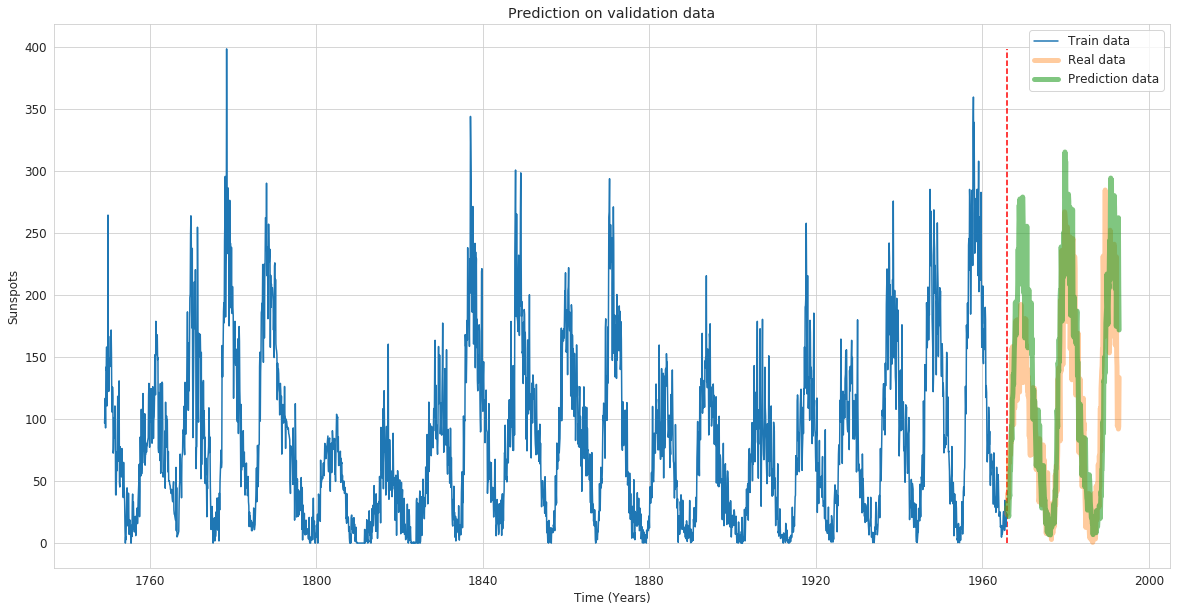

In [31]:
plt.plot(train_data, label='Train data')
plt.plot(val_data, label='Real data', linewidth=5, alpha=0.4)
plt.plot(val_pred, label='Prediction data', linewidth=5, alpha=0.6)
plt.vlines(val_data.index[0], train_data.values.min(), train_data.values.max(), 'red', '--')
plt.xlabel("Time (Years)")
plt.ylabel("Sunspots")
plt.title('Prediction on validation data')
plt.legend()

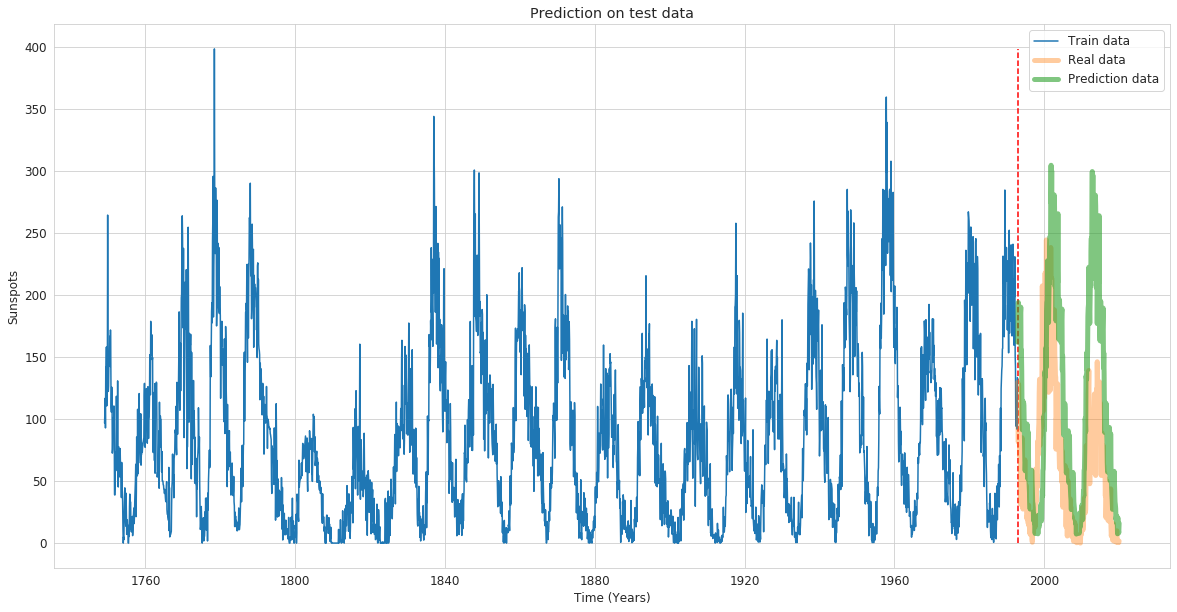

In [32]:
plt.plot(train_data.append(val_data), label='Train data')
plt.plot(test_data, label='Real data', linewidth=5, alpha=0.4)
plt.plot(test_pred, label='Prediction data', linewidth=5, alpha=0.6)
plt.vlines(test_data.index[0], train_data.values.min(), train_data.values.max(), 'red', '--')
plt.xlabel("Time (Years)")
plt.ylabel("Sunspots")
plt.title('Prediction on test data')
plt.legend()

LSTM

In [7]:
from sklearn.preprocessing import MinMaxScaler

In [8]:
y = df['Monthly Mean Total Sunspot Number']
x = df.index.values

In [9]:
scaler = MinMaxScaler()

In [10]:
mms_y = scaler.fit_transform(y.values.reshape(-1,1))

In [11]:
train_data = mms_y[:int(len(mms_y)*0.8)]
val_data = mms_y[int(len(mms_y)*0.8):int(len(mms_y)*0.9)]
test_data = mms_y[int(len(mms_y)*0.9):]

In [12]:
print('Train', len(train_data))
print('Validation:', len(val_data))
print('Test', len(test_data))

Train 2601
Validation: 325
Test 326


In [13]:
#split into train and test sets
train_size = int(len(mms_y) * 0.8)
test_size = len(mms_y) - train_size
train, test = mms_y[0:train_size,:], mms_y[train_size:len(mms_y),:]
print(len(train), len(test))

2601 651


In [14]:
def simple_look(dataset, look_back=1):
    dataX = dataset[:-(look_back + 1), 0]
    dataY = dataset[look_back:-1, 0]
    return np.reshape(dataX, (len(dataX), 1)), np.reshape(dataY, (len(dataY), 1))

In [15]:
#reshape into X=t and Y=t+1
look_back = 1
trainXb, trainYb = simple_look(train_data, look_back)
valXb, valYb = simple_look(val_data, look_back)
testXb, testYb = simple_look(test_data, look_back)

In [16]:
#reshape input to be [samples, time steps, features]
trainX = np.reshape(trainXb, (trainXb.shape[0], 1, trainXb.shape[1]))
valX = np.reshape(valXb, (valXb.shape[0], 1, valXb.shape[1]))
testX = np.reshape(testXb, (testXb.shape[0], 1, testXb.shape[1]))

In [20]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Flatten
from livelossplot import PlotLossesKeras
from keras_sequential_ascii import keras2ascii

In [21]:
model = Sequential()
model.add(LSTM(256, input_shape=(1, look_back), return_sequences=True))
model.add(LSTM(128))
model.add(Dense(1))
keras2ascii(model)

           OPERATION           DATA DIMENSIONS   WEIGHTS(N)   WEIGHTS(%)

               Input   #####      1    1
                LSTM   LLLLL -------------------    264192    57.3%
                tanh   #####      1  256
                LSTM   LLLLL -------------------    197120    42.7%
                tanh   #####         128
               Dense   XXXXX -------------------       129     0.0%
                       #####           1


In [22]:
model.compile(loss='mean_squared_error', optimizer='adam',  metrics=['mae'])

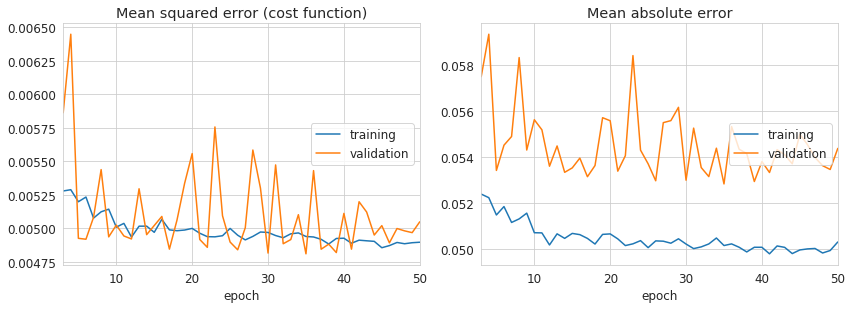

Mean squared error (cost function):
training   (min:    0.005, max:    0.006, cur:    0.005)
validation (min:    0.005, max:    0.007, cur:    0.005)

Mean absolute error:
training   (min:    0.050, max:    0.057, cur:    0.050)
validation (min:    0.053, max:    0.067, cur:    0.054)


In [24]:
model.fit(trainX,
          trainYb,
          epochs=50,
          validation_data=(valX, valYb),
          callbacks=[PlotLossesKeras()],
          batch_size=1,
          verbose=2)

In [26]:
trainPredict = model.predict(trainX)
valPredict = model.predict(valX)
testPredict = model.predict(testX)

trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform(trainYb)

valPredict = scaler.inverse_transform(valPredict)
valY = scaler.inverse_transform(valYb)

testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform(testYb)

valScore = mean_absolute_error(valY, valPredict)
print('Val Score: %.2f MSE' % (valScore))
testScore = mean_absolute_error(testY, testPredict)
print('Test Score: %.2f MSE' % (testScore))

Val Score: 21.66 MSE
Test Score: 15.95 MSE


In [83]:
val_pred_df = pd.DataFrame(valPredict)
val_pred_df.index = val_data.index[2:]
test_pred_df = pd.DataFrame(testPredict)
test_pred_df.index = test_data.index[2:]

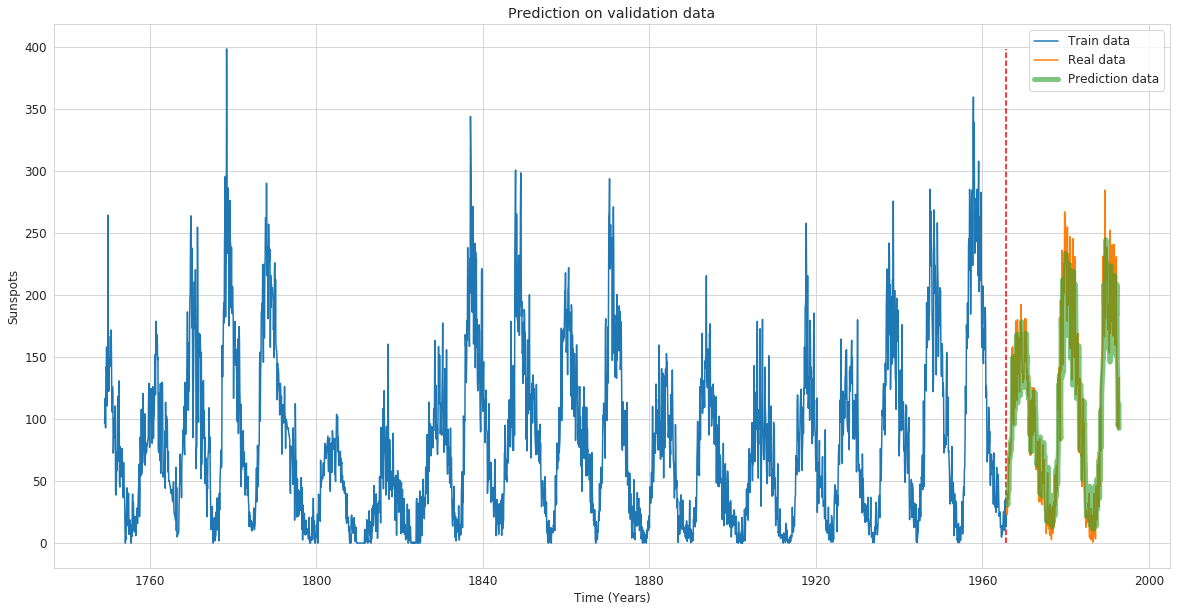

In [84]:
plt.plot(train_data.index, train_data.values, label='Train data')
plt.vlines(train_data.index[-1], train_data.values.min(), train_data.values.max(), 'red', '--')
plt.plot(val_data.index, val_data.values, label='Real data')
plt.plot(val_pred_df, label='Prediction data', linewidth=5, alpha=0.6)
plt.xlabel("Time (Years)")
plt.ylabel("Sunspots")
plt.title('Prediction on validation data')
plt.legend()

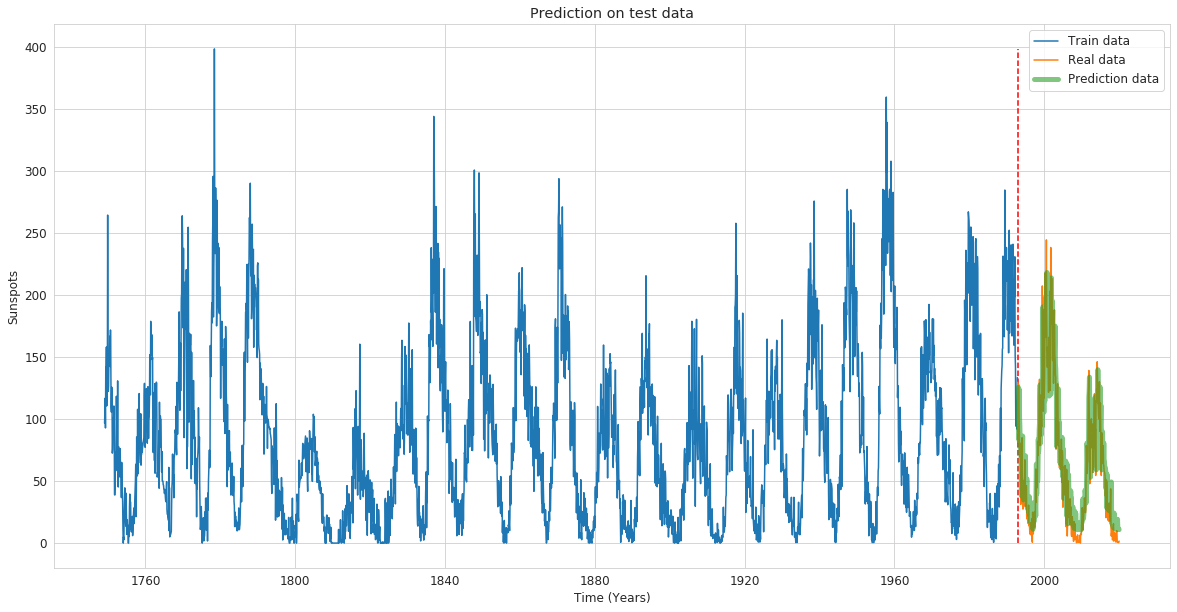

In [85]:
plt.plot(train_data.append(val_data), label='Train data')
plt.vlines(test_data.index[0], train_data.values.min(), train_data.values.max(), 'red', '--')
plt.plot(test_data.index, test_data.values, label='Real data')
plt.plot(test_pred_df, label='Prediction data', linewidth=5, alpha=0.6)
plt.xlabel("Time (Years)")
plt.ylabel("Sunspots")
plt.title('Prediction on test data')
plt.legend()